In [1]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
from matplotlib import cm
plt.rcParams.update(newparams)

In [2]:
def tridiag(v, d, w, N):
    # Help function 
    # Returns a tridiagonal matrix A=tridiag(v, d, w) of dimension N x N.
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

In [3]:
def create_g_vec(M, N, x, y, gx_lower, gx_upper, gy_lower, gy_upper):
    # Creating a matrix, adding the correct boundary conditions, and returning as a vector
    g_matrix = np.zeros((M-1, N-1))
    # x, y=0
    
    # print(len(g_matrix[0, :]))
    # print(gx_lower(x[:-2]))
    # print(len(gx_lower(x[:-2])))
    
    
    g_matrix[0, :] += gx_lower(x[:-2])
    # x, y=-1
    g_matrix[-1, :] += gx_upper(x[2:])
    
    # y, x=0
    g_matrix[1:, 0] += gy_lower(y[1:-2])
    g_matrix[:, 0] += gy_lower(y[1:-1])

    # y, x=-1
    g_matrix[:-1, -1] += gy_upper(y[2:-1])
    g_matrix[:, -1] += gy_upper(y[1:-1])
    return np.ravel(g_matrix)

# Boundary
def g_zeros(x):
    return 0

In [4]:
def create_f_vec(f, x, y):
    X, Y = np.meshgrid(x[1:-1], y[1:-1])
    f_matrix = f(X, Y)
    # Create matrix for the instances where f has returned a constant instead of a matrix
    if type(f_matrix) == int or type(f_matrix) == float:
        f_matrix = np.ones_like(X)*f_matrix
    return np.ravel(f_matrix) 

def f_zeros(x, y):
    return 0

In [5]:
def create_rhs_vec(rhs_func, x, y, a, r):
    X, Y = np.meshgrid(x[1:-1], y[1:-1])
    rhs_matrix = rhs_func(X, Y, a, r)
    # Create matrix for the instances where rhs_func has returned a constant instead of a matrix
    if type(rhs_matrix) == int or type(rhs_matrix) == float:
        rhs_matrix = np.ones_like(X)*rhs_matrix
    return np.ravel(rhs_matrix)

def rhs_zeros(x, y, a, r):
    return 0

In [6]:
def solver(f, a, r=2, M=10, x_bdd = 1, y_bdd = 2, gx_lower = g_zeros, gx_upper = g_zeros, gy_lower = g_zeros, gy_upper = g_zeros, rhs_func = rhs_zeros):
    h = 1/M
    k = np.abs(r)*h
    
    x = np.linspace(0,x_bdd,M+1)    # Gridpoints on the x-axis
    y = np.arange(0,y_bdd+k,k)    # Gridpoints on the y-axis

    # OBS IKKE SLETT -> Til lineær konvergens
    #y[-1] = 2
    
    N = len(y)-1

    # Creating A_h matrix
    B = tridiag(-a, 2*(a+1), -a, (M-1))
    C = tridiag(0, 0, 1, M-1)
    above_diag = np.eye(N-1,N-1,k=1) # Above diagonal
    along_diag = np.eye(N-1,N-1) # Diagonal
    below_diag = np.eye(N-1,N-1,k=-1) # Below diagonal
    A_h = (np.kron(above_diag, -C) + np.kron(along_diag, B) + np.kron(below_diag, -C.T))

    # Creating f-vector
    f_vec = create_f_vec(f, x, y)

    # Creating g-vector
    g_vec = create_g_vec(M, N, x, y, gx_lower, gx_upper, gy_lower, gy_upper)

    # Create rhs-vector (for task c)
    rhs_vec = create_rhs_vec(rhs_func, x, y, a, r)

    # Solving system
    U = np.linalg.solve(A_h, (f_vec-rhs_vec)*(h**2) + g_vec)

    # Reshaping and padding from vector to (M+1)x(M+1)-matrix
    U = U.reshape((N-1, M-1))
    U = np.pad(U, 1)

    # Adding bdd-conditions to padded layer
    U[0,:]  = gx_lower(x)
    U[-1,:] = gx_upper(x)
    U[:,0]  = gy_lower(y)
    U[:,-1] = gy_upper(y)

    # OBS IKKE SLETT -> Til lineær konvergens
    # U[0,:]  = U[1,:] 
    # U[-1,:] = U[-2,:]
    # U[:,0]  = U[:,1] 
    # U[:,-1] = U[:,-2]
    
    # Returning
    return x, y, U


In [7]:
# For plotting the solutions
def plot_solution(x, y, U, txt='Solution'):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    # fig.set_figwidth(10)
    # fig.set_figheight(10)
    fig.set_figwidth(15)
    fig.set_figheight(10)
    X, Y = np.meshgrid(x,y)
    #ax.plot_wireframe(T, X, U)
    ax.plot_surface(X, Y, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('x')
    plt.ylabel('y')
    # ax.set_zlabel("z", labelpad=20)
    plt.ticklabel_format(style="scientific")
    
    plt.title(txt, fontsize = 20)
    plt.show()


# def plot_solution_2(x, y, U1, U2, label1, label2):
#     fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#     #fig.set_figwidth(10)
#     #fig.set_figheight(10)
    
#     X, Y = np.meshgrid(x,y)
    
#     ax1.plot_surface(X, Y, U1, cmap=cm.coolwarm)
#     ax1.xlabel('x')
#     ax1.ylabel('y') 
#     ax1.set_title(label=label1)

#     ax2.plot_surface(X, Y, U2, cmap=cm.coolwarm)
#     ax2.xlabel('x')
#     ax2.ylabel('y') 
#     ax2.set_title(label=label2)
#     plt.show()


## Experimenting with simple choices for g and f

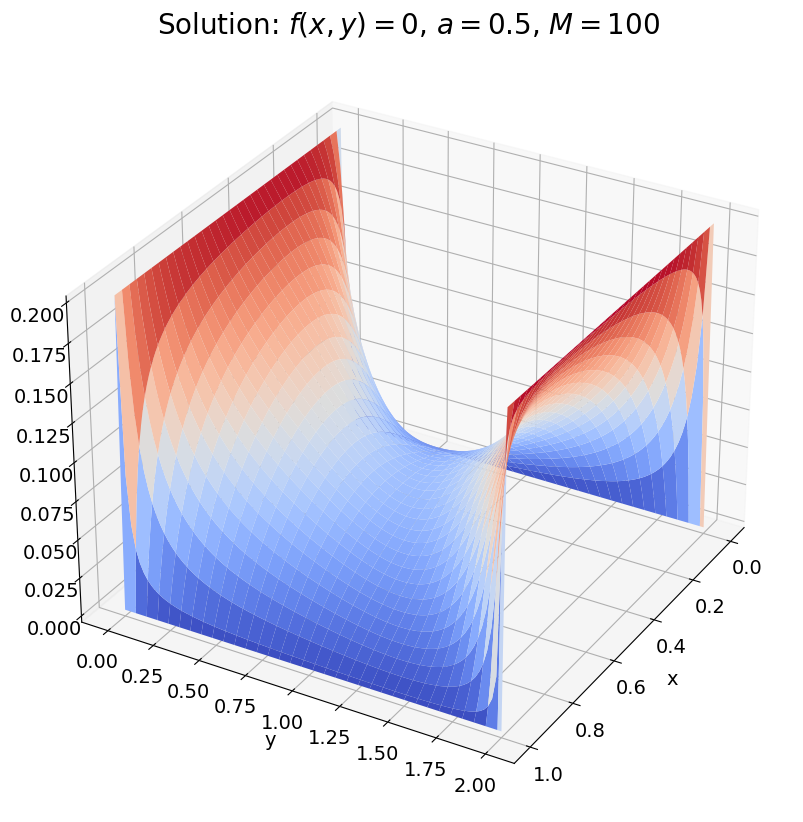

In [26]:
def gx_lower1(x):
    return 0.2
def gx_upper1(x):
    return 0.2

x, y, U = solver(f_zeros, a=0.5, M=100, gx_lower=gx_lower1, gx_upper=gx_upper1)

plot_solution(x, y, U, txt=r'Solution: $f(x,y)=0$, $a=0.5$, $M=100$')

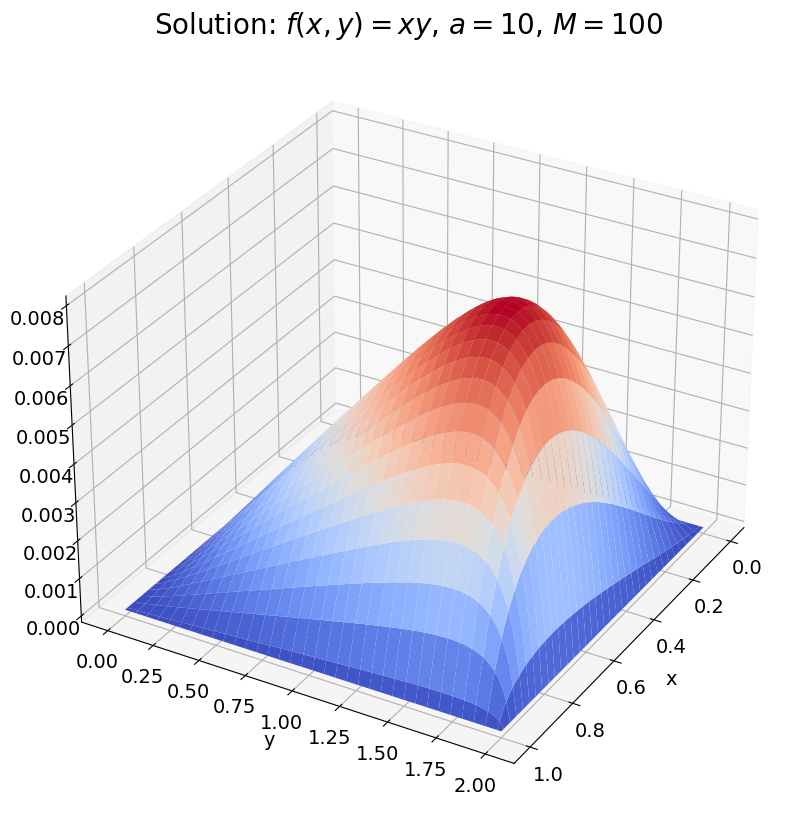

In [9]:
def f_temp(x, y):
    return x*y
x, y, U = solver(f_temp, a=10, M=100)

plot_solution(x, y, U, txt=r'Solution: $f(x,y)=xy$, $a=10$, $M=100$')

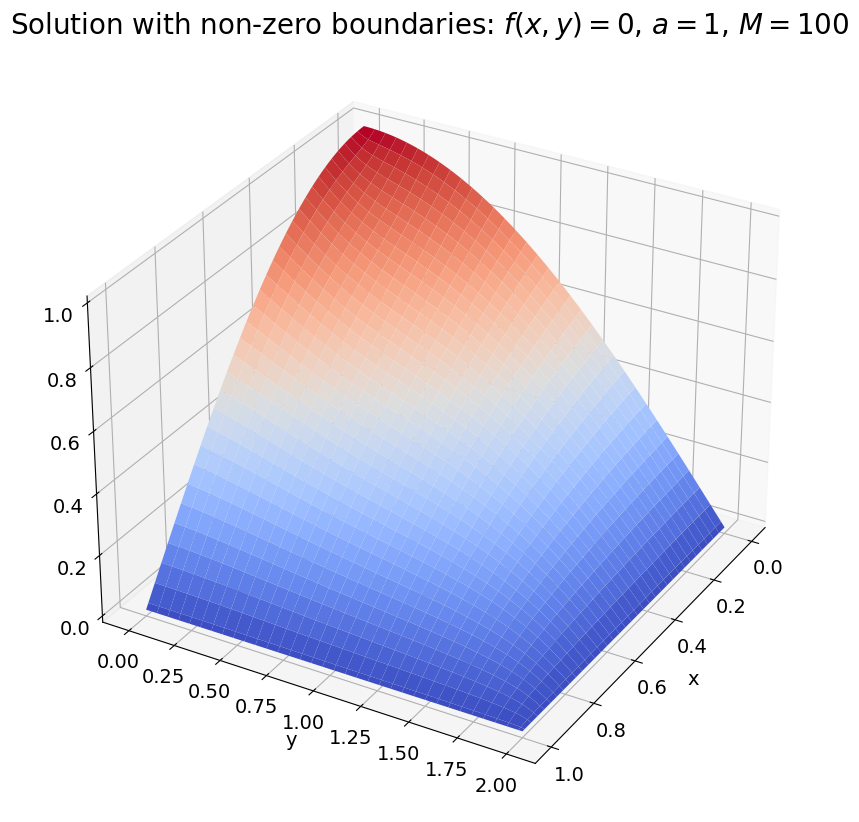

In [10]:

def gx_lower2(x):
    return np.cos(0.5*np.pi*x)
def gy_lower2(y):
    return np.cos(0.25*np.pi*y)
def f_temp(x, y):
    return 0

x, y, U = solver(f_temp, a=1, r=2, M=100, gx_lower=gx_lower2, gy_lower=gy_lower2)
plot_solution(x, y, U, txt=r'Solution with non-zero boundaries: $f(x,y)=0$, $a=1$, $M=100$')


## Checking convergence rates

Using the function $u(x,y) = \sin(\pi x)\sin(\frac{\pi}{2}y)$ as the exact solution. This function was chosen because it is zero on the boundary for $\Omega = [0,1]\times[0,2]$.

In [11]:
# Function 1
def u_exact1(x, y):
    return np.sin(np.pi*x)*np.sin(0.5*np.pi*y)
def rhs_func_1(x, y, a, r):
    return r*(np.pi**2)*np.cos(np.pi*x)*np.cos(0.5*np.pi*y)-u_exact1(x, y)*(np.pi**2)*(a+1+0.25*(r**2))


In [12]:
# Function for calculating and plotting the convergence
def convergence(u_exact, rhs, P=4, M_start=10, plot = False, write_r_val=False, plot_testing = [False, False, False], f=f_zeros, a_val=1, r_val=2, gx_lower=g_zeros, gx_upper=g_zeros, gy_lower=g_zeros, gy_upper=g_zeros):
    Hconv = np.zeros(P)
    Econv = np.zeros(P)
    M_temp = M_start
    for p in range(P):
        # Solving the system using 
        x, y, U = solver(f, a_val, r=r_val, M=M_temp, rhs_func = rhs, gx_lower=gx_lower, gx_upper=gx_upper, gy_lower=gy_lower, gy_upper=gy_upper)
        
        # Calculating errror
        X, Y = np.meshgrid(x, y)
        U_ex = u_exact(X, Y)
        Eh = U_ex-U
        # Eh = U_ex.clip(min=0)-U

        # Plotting solutions and errors, primarily used for debugging
        if plot_testing[0] == True:
            plot_solution(x, y, U_ex, r"Exact function $U_{exact}$")
        if plot_testing[1] == True:
            plot_solution(x, y, U, r"Numerical solution $U$" + ", " + f"M = {M_temp}")
        if plot_testing[2] == True:
            plot_solution(x, y, np.abs(Eh), r"Error = $|U_{exact}-U|$" + ", " + f"M = {M_temp}")

        # print(np.abs(Eh))

        # Adding stepsize and error to lists
        Hconv[p] = (x[1]-x[0])
        Econv[p] = np.max(np.abs(Eh))
        
        #Increasing M
        M_temp = 2*M_temp
        
    # Determining the order using np.polyfit
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]

    #Plotting
    if plot == True:
        plt.loglog(Hconv,Econv,'o-', label='p={:.3f}'.format(order))
        if write_r_val == True:
            plt.title(f"Convergence: r={round(r_val, 5)}")
        else:
            plt.title(r"Convergence")
        plt.grid('on')
        plt.xlabel('h')
        plt.ylabel(r'Error')
        plt.legend()
        plt.show()
    else:
        return Hconv, Econv, order

In [13]:
#convergence(u_exact1, rhs_func_1, P=6, M_start=4, plot = True, plot_testing=[True, True, True])

Testing for a function that is not zero on the boundary

In [14]:
# Function 2
def u_exact2(x, y):
    return (x**2)*np.cos(5*x)
def rhs_func_2(x, y, a, r):
    return (a+1) * ((2-25*x**2)*np.cos(5*x) - 20*x*np.sin(5*x))

# Boundaries
def gx_lower3(x):
    return u_exact2(x, 0)
def gx_upper3(x):
    return u_exact2(x, 2)
def gy_lower3(y):
    return u_exact2(0, y)
def gy_upper3(y):
    return u_exact2(1, y)

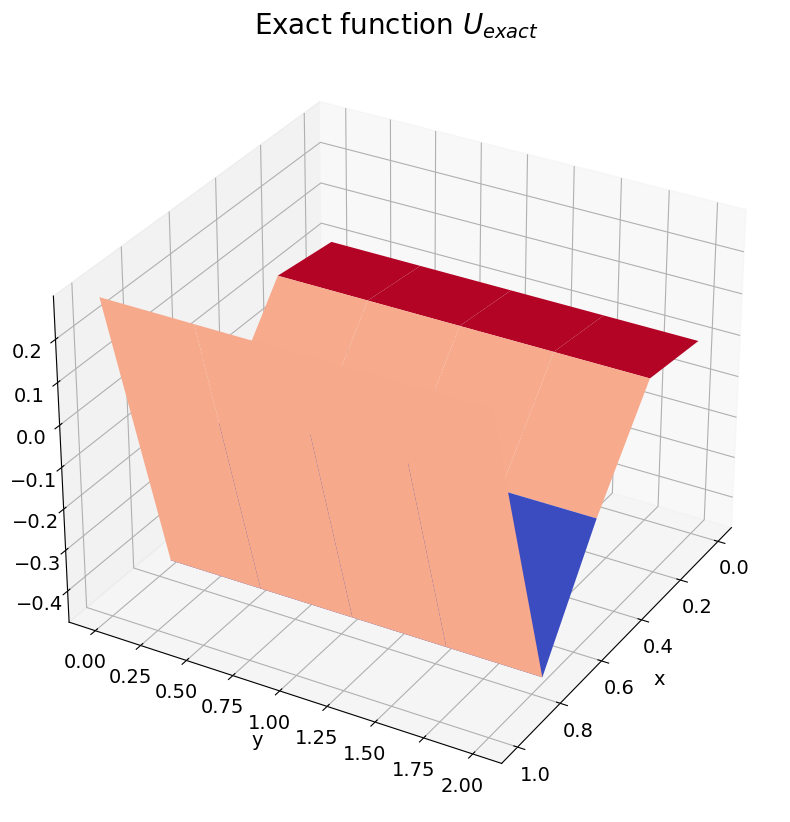

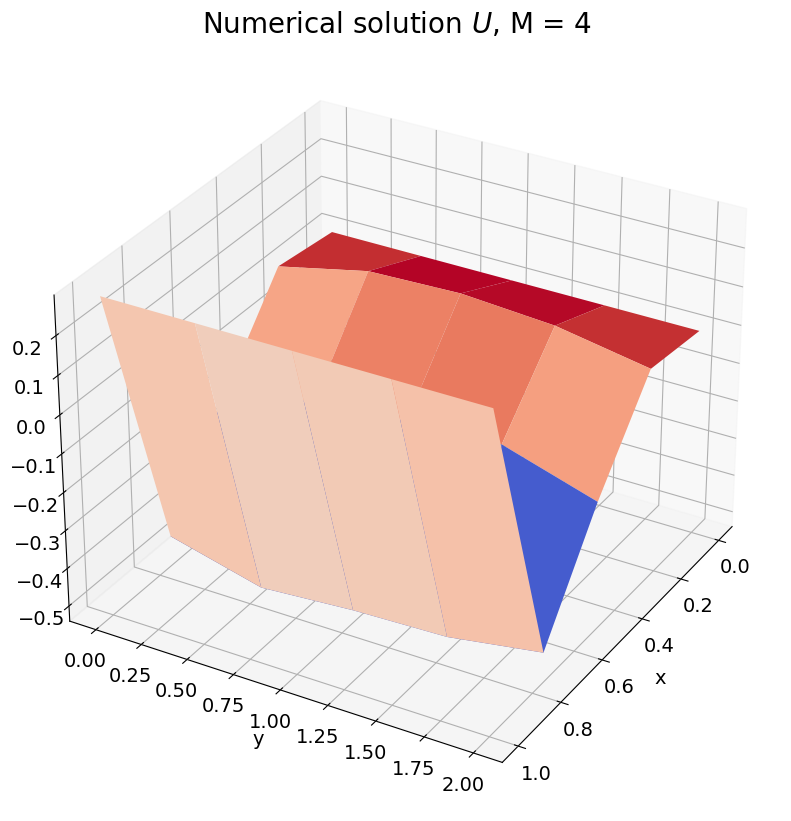

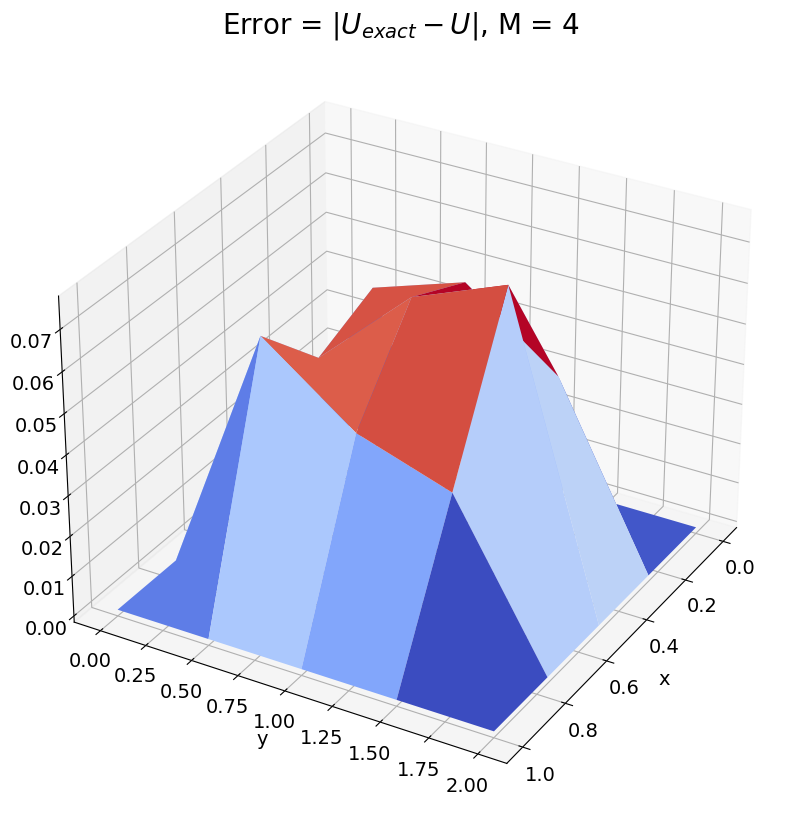

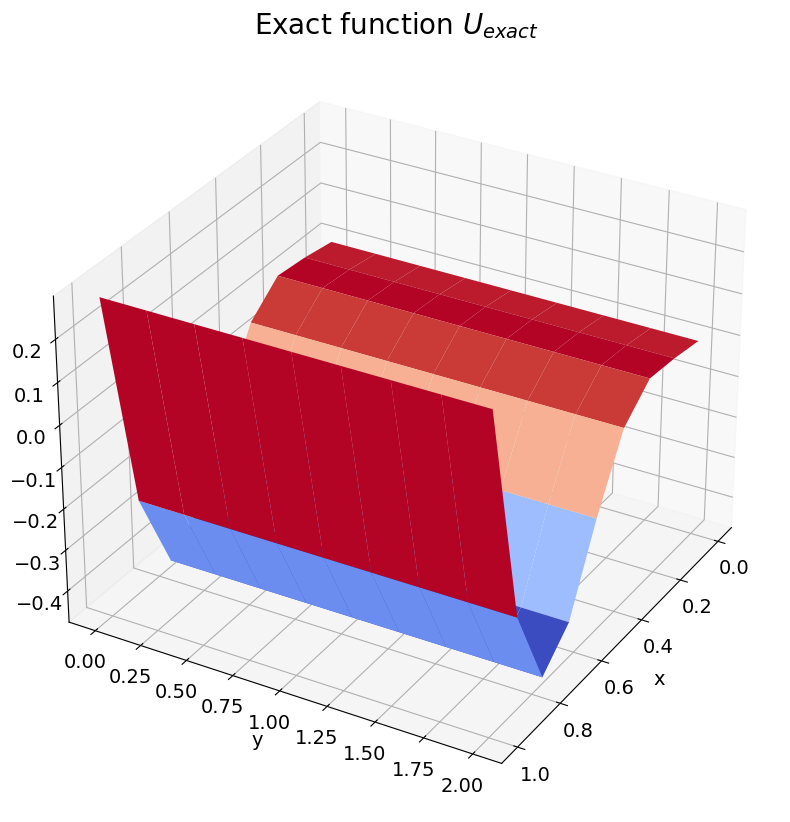

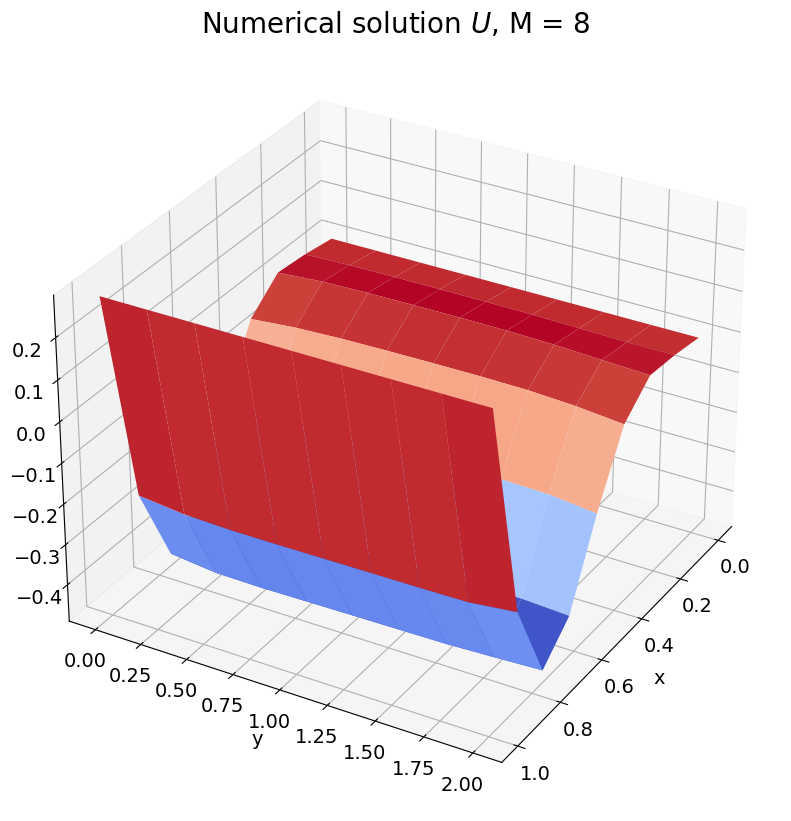

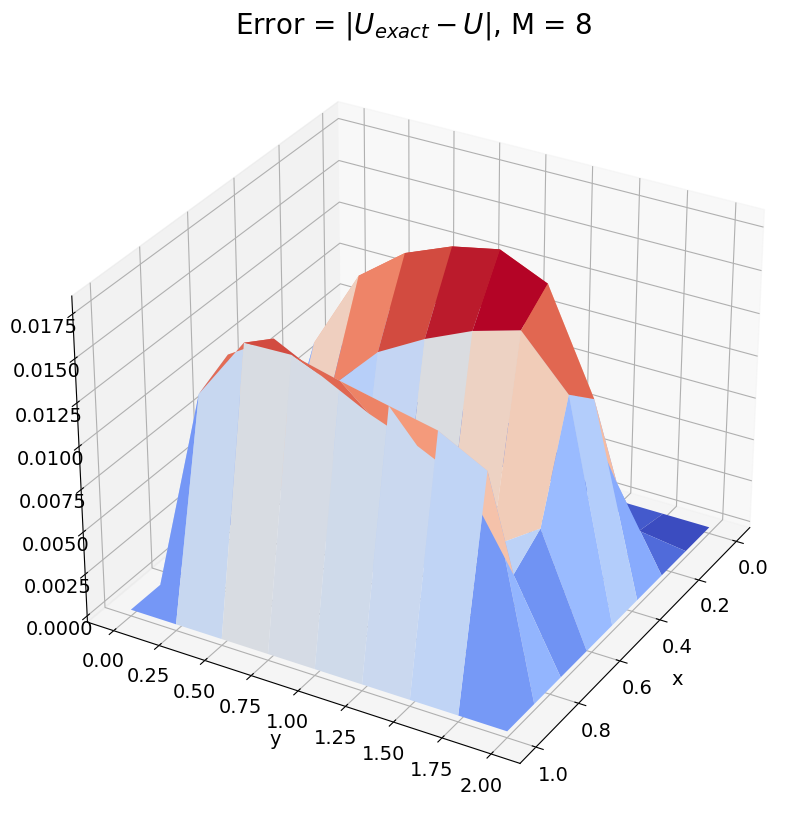

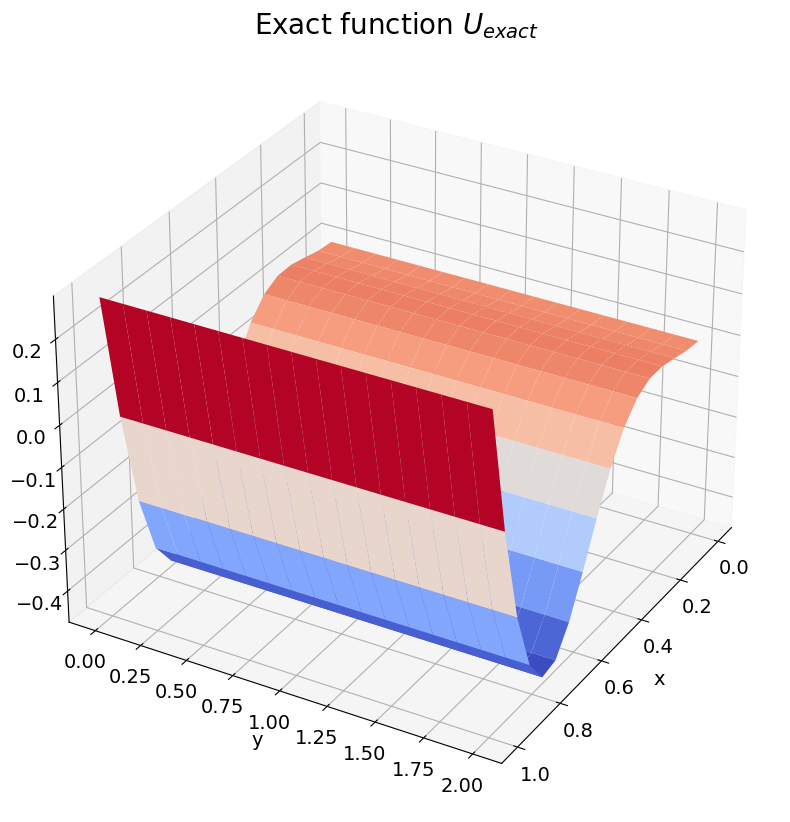

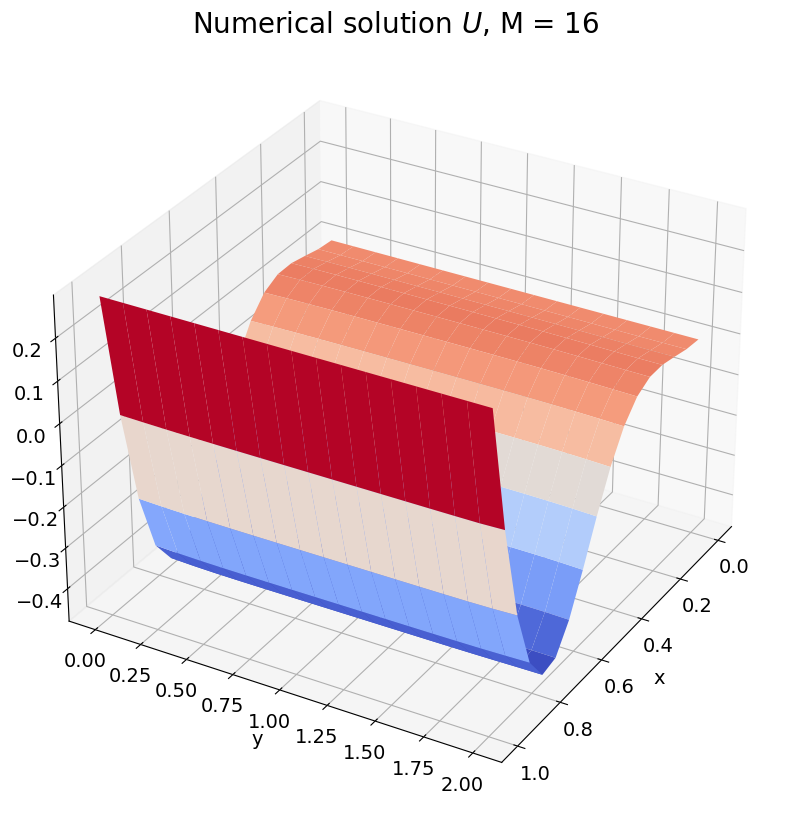

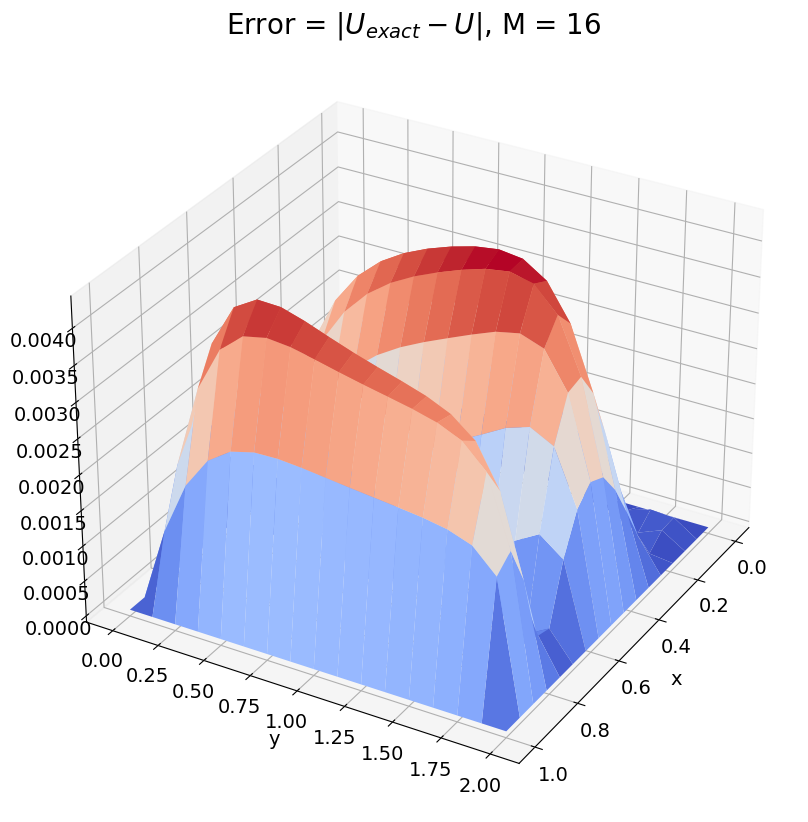

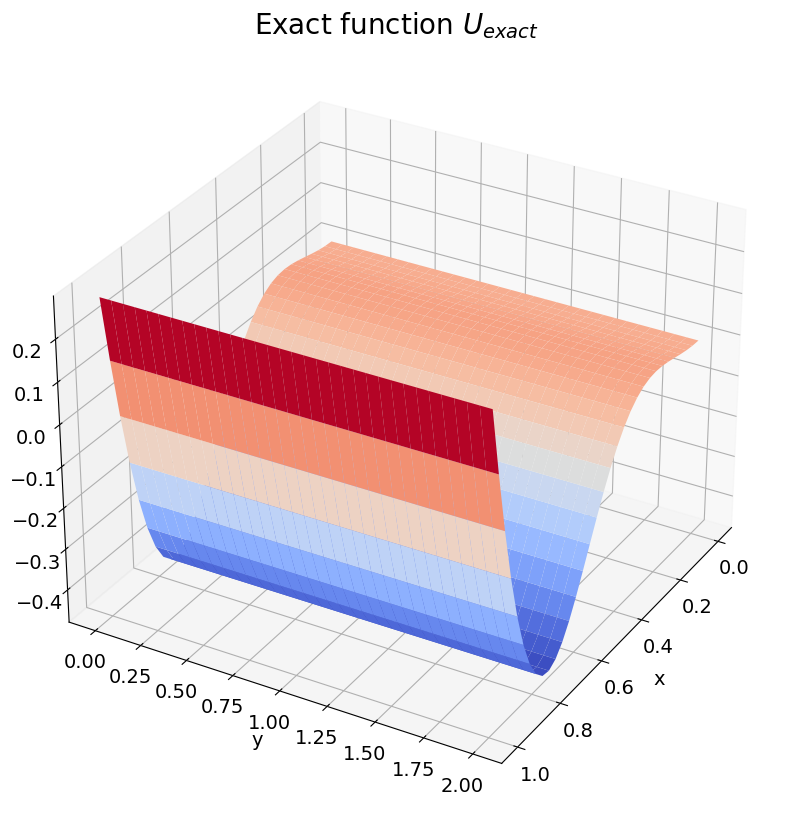

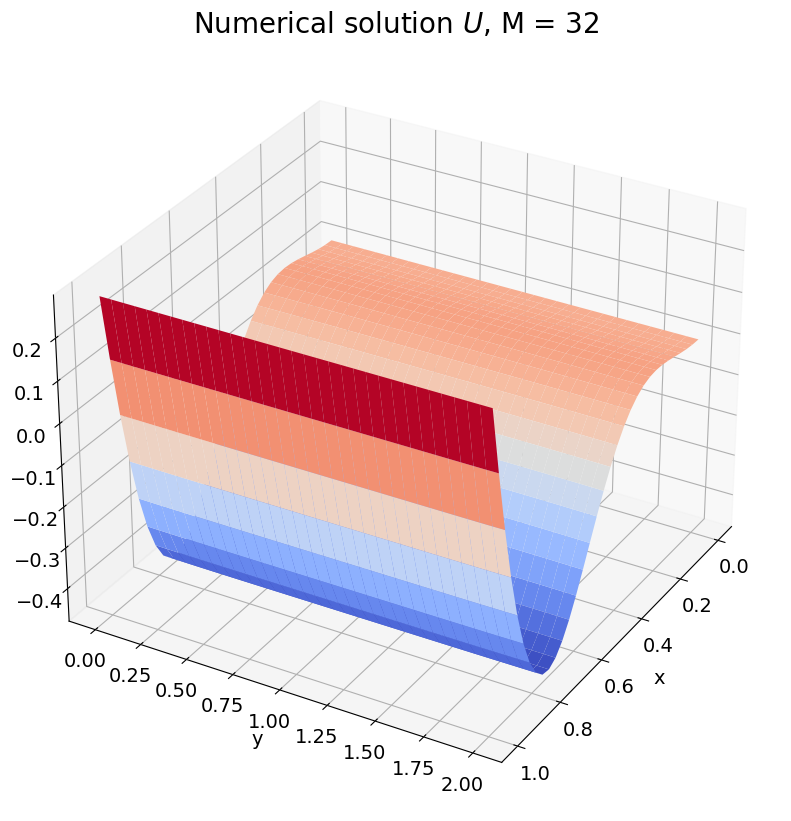

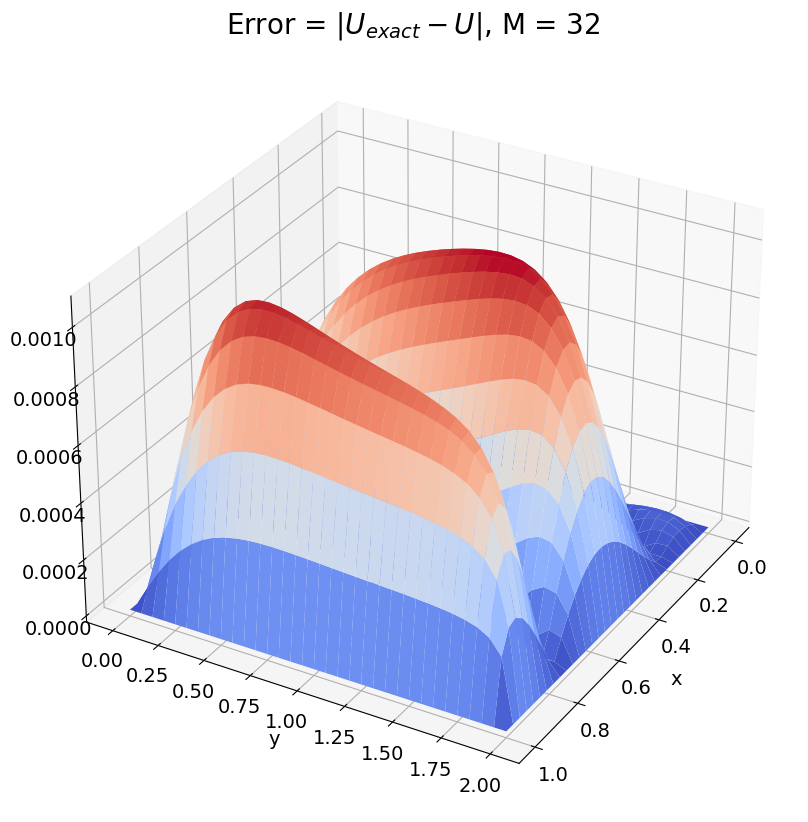

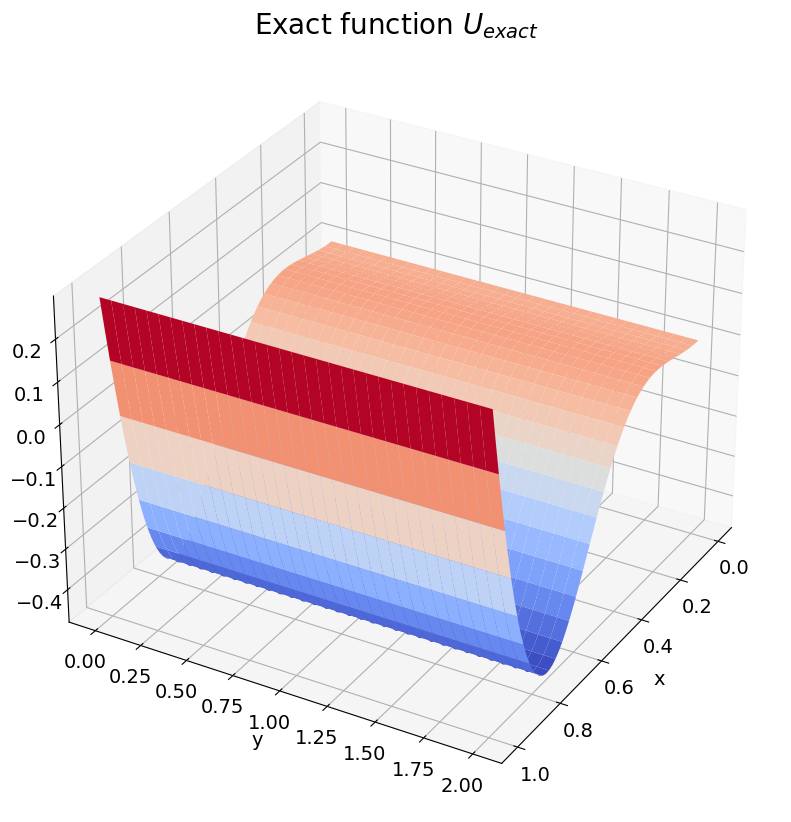

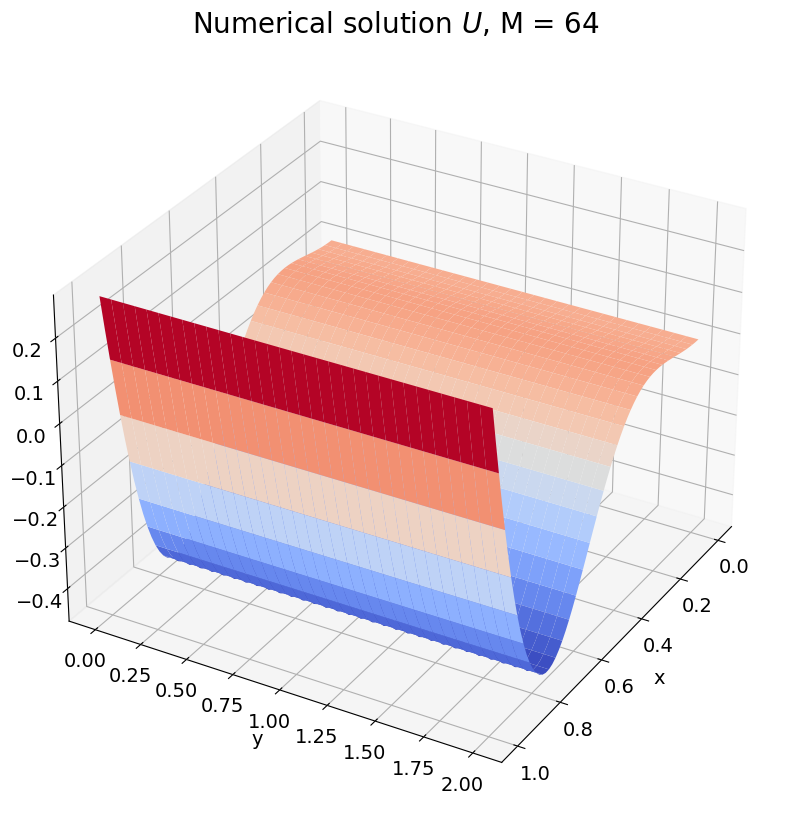

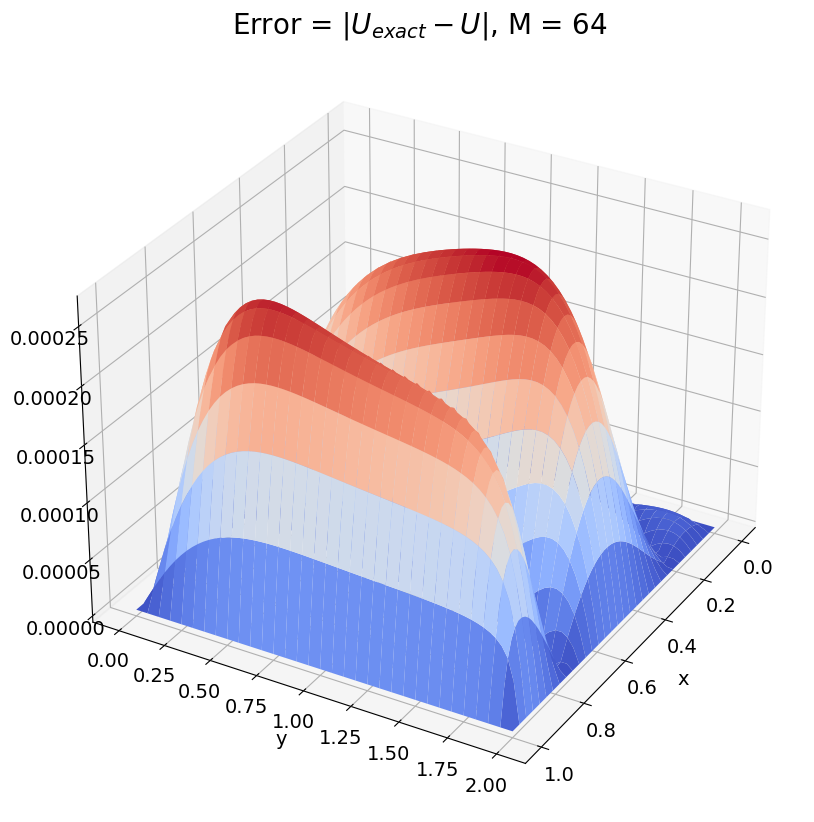

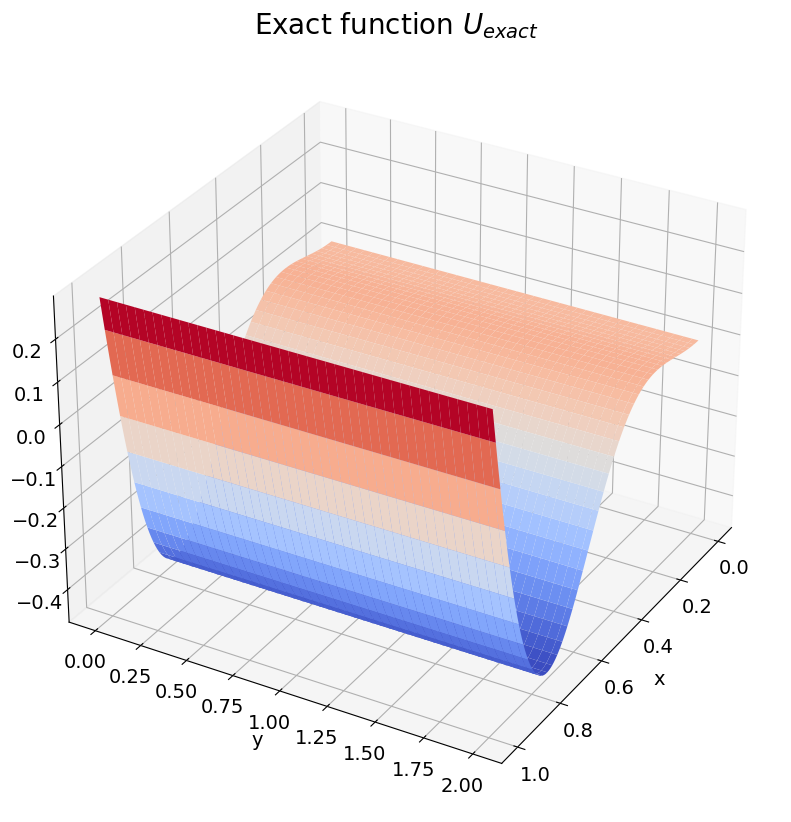

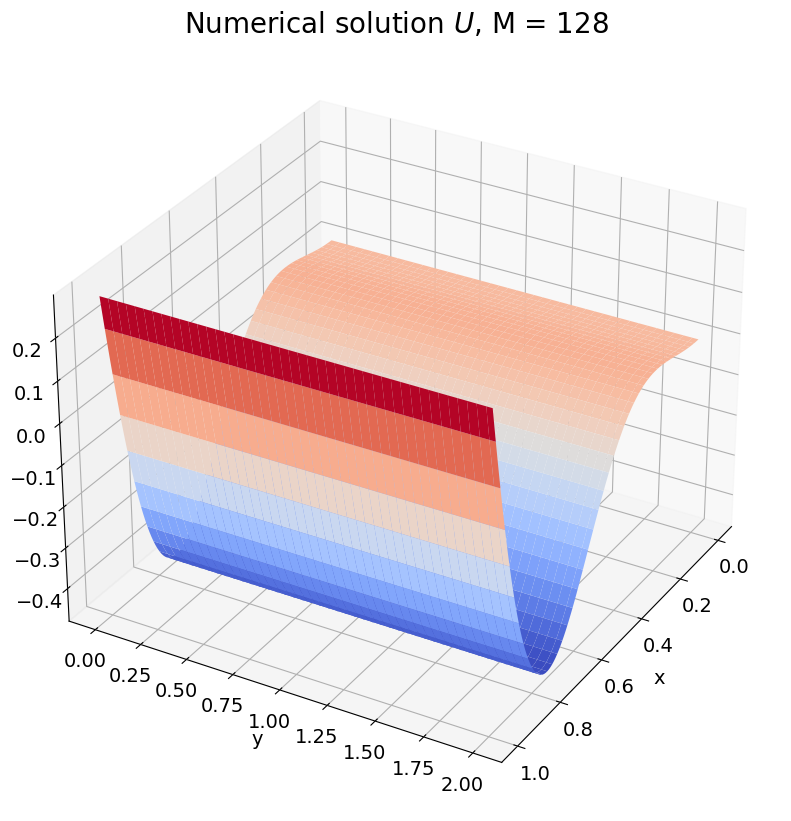

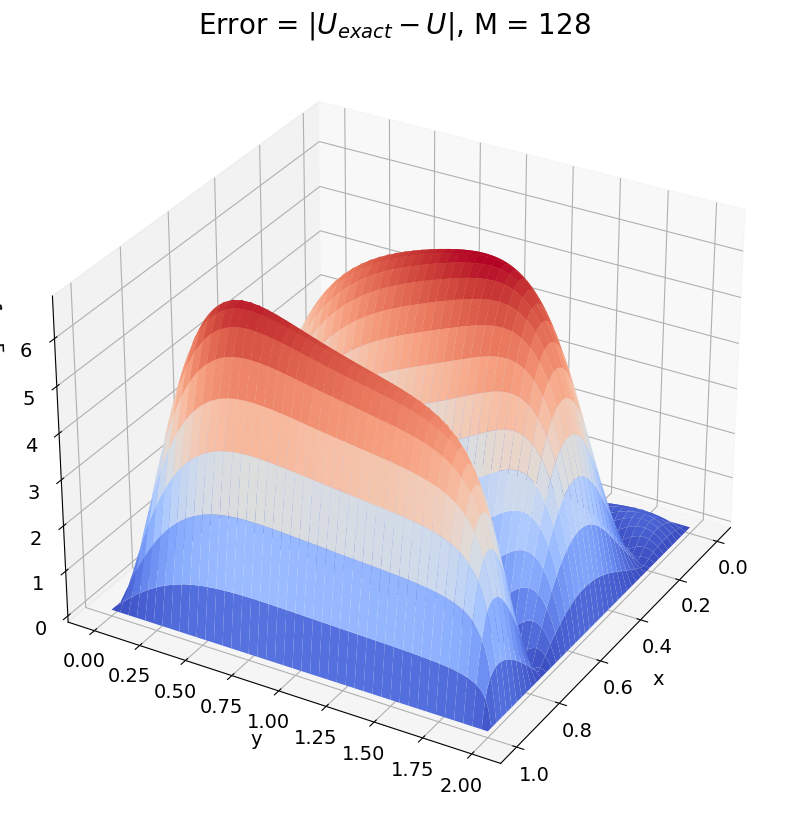

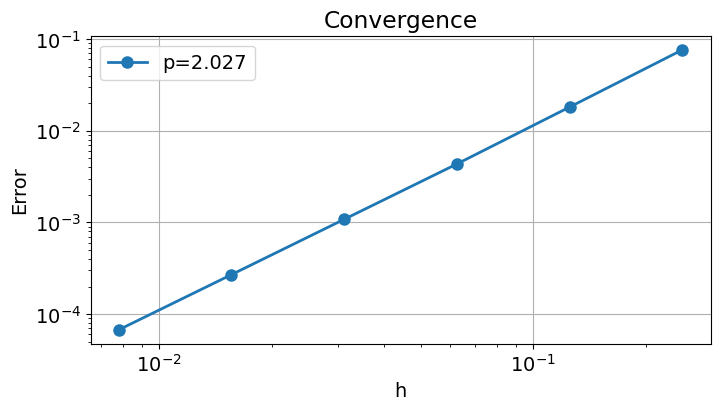

In [15]:
convergence(u_exact2, rhs_func_2, P=6, M_start=4, plot = True, gx_lower=gx_lower3, gx_upper=gx_upper3, gy_lower=gy_lower3, gy_upper=gy_upper3, plot_testing=[True, True, True])

See that the order $p \simeq 2$, which is nice.

## Task 1d

In [17]:
# Function 1
def u_exact1(x, y):
    return np.sin(np.pi*x)*np.sin(0.5*np.pi*y)
def rhs_func_1(x, y, a, r):
    return r*(np.pi**2)*np.cos(np.pi*x)*np.cos(0.5*np.pi*y)-u_exact1(x, y)*(np.pi**2)*(a+1+0.25*(r**2))

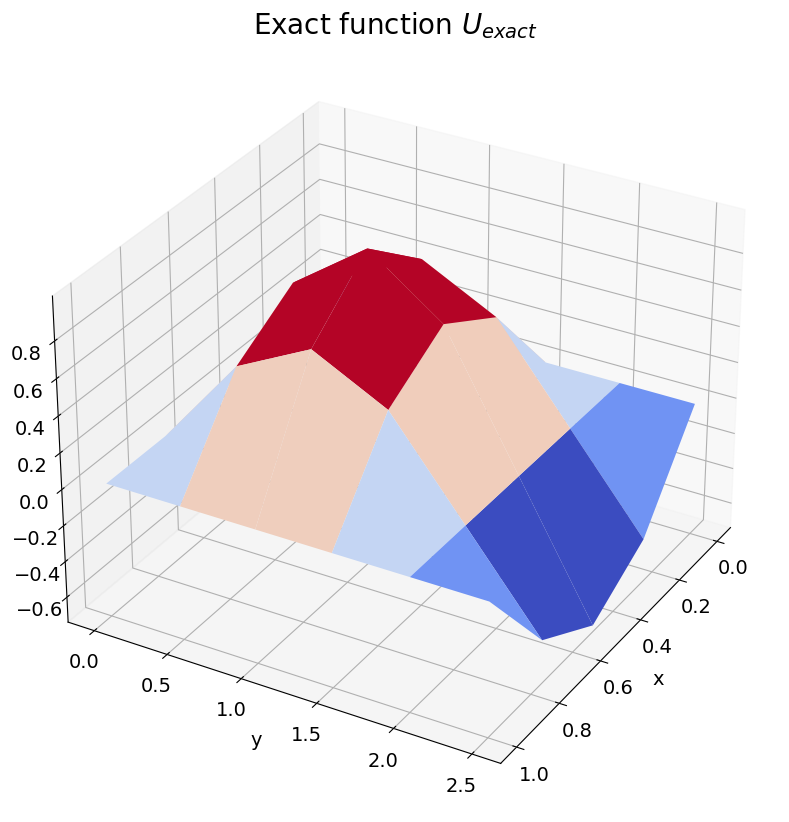

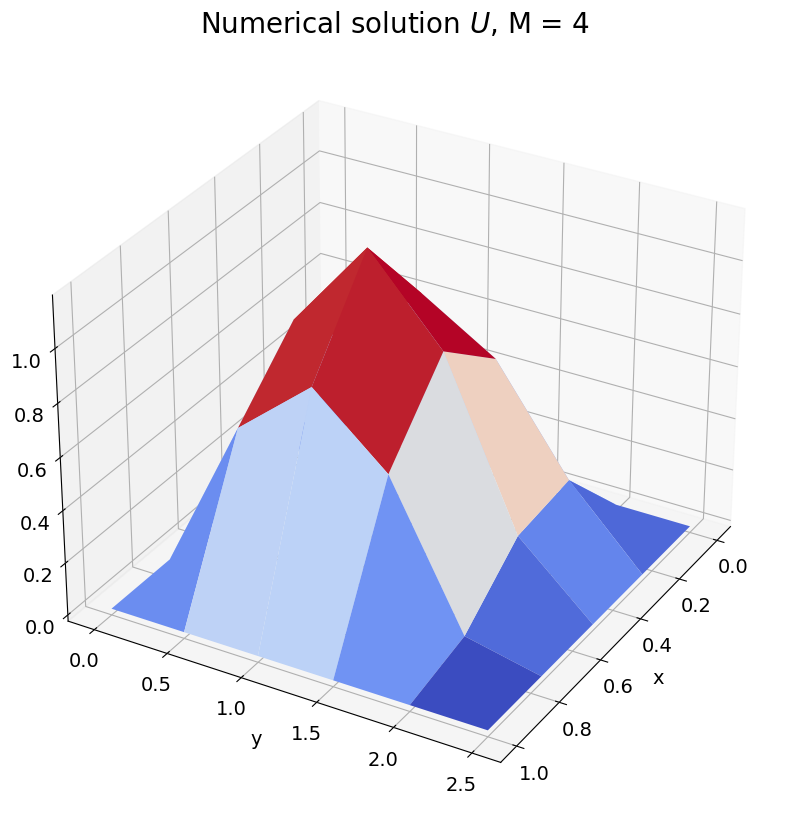

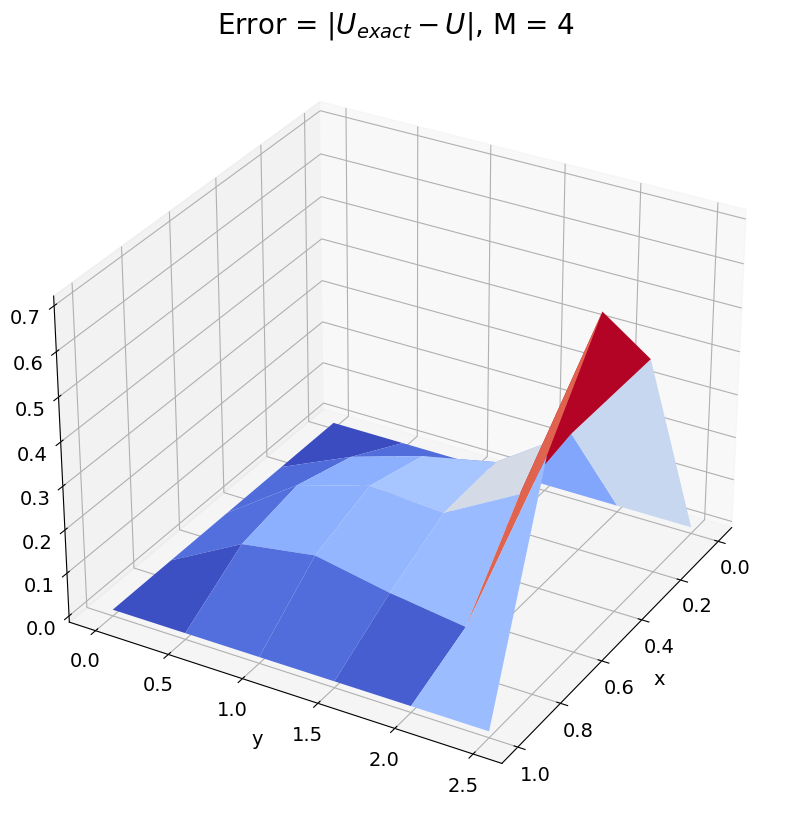

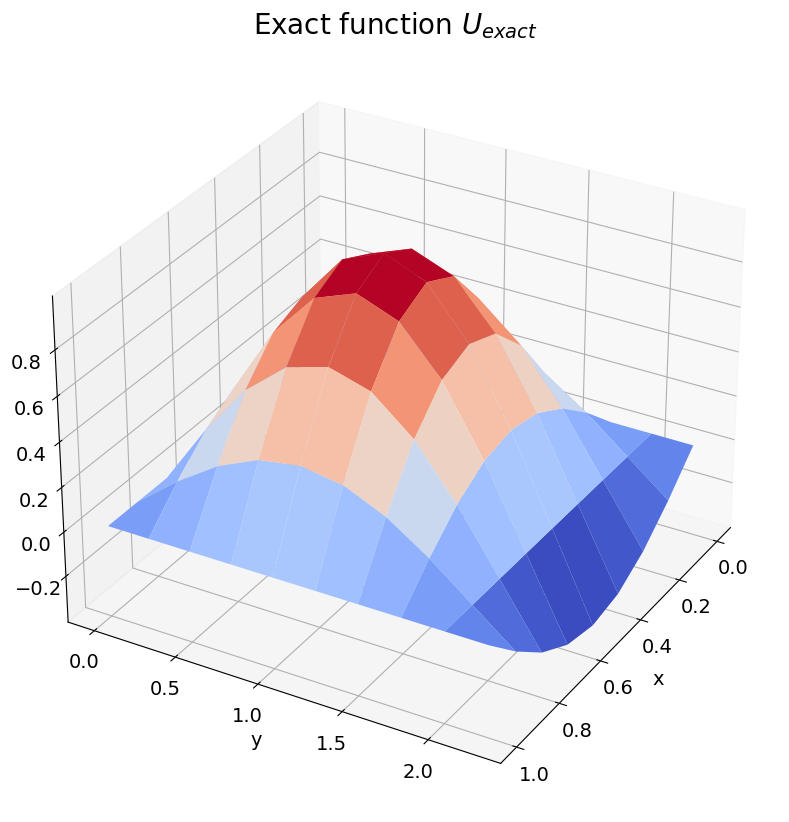

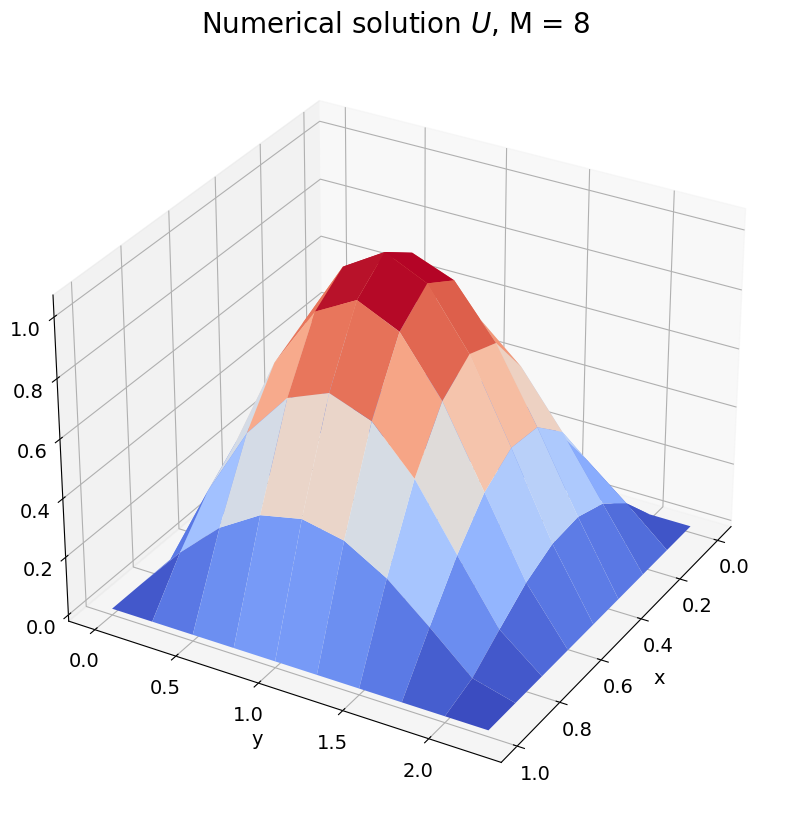

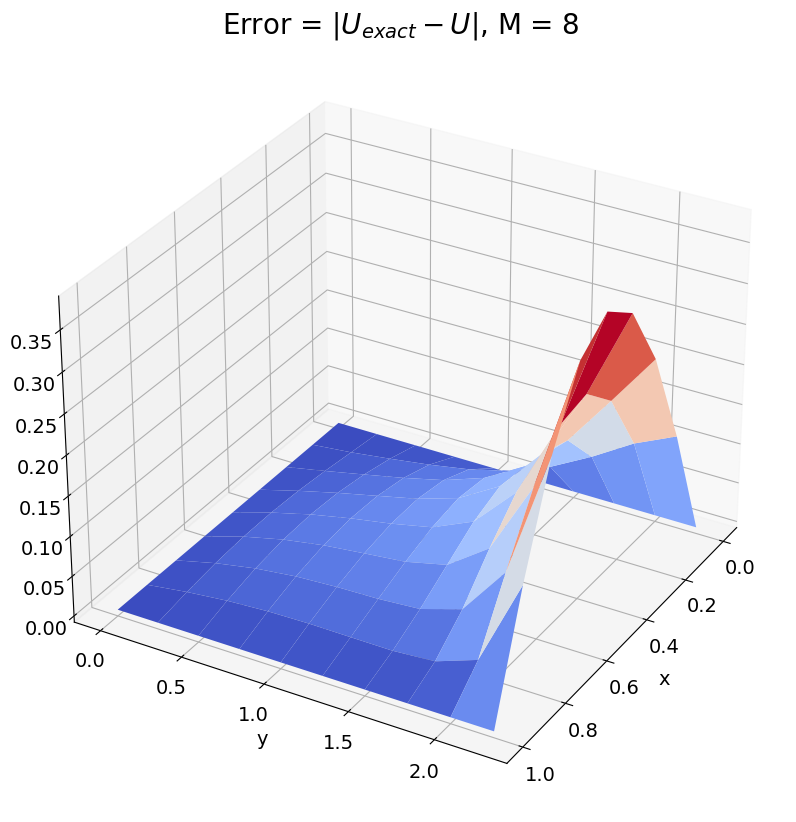

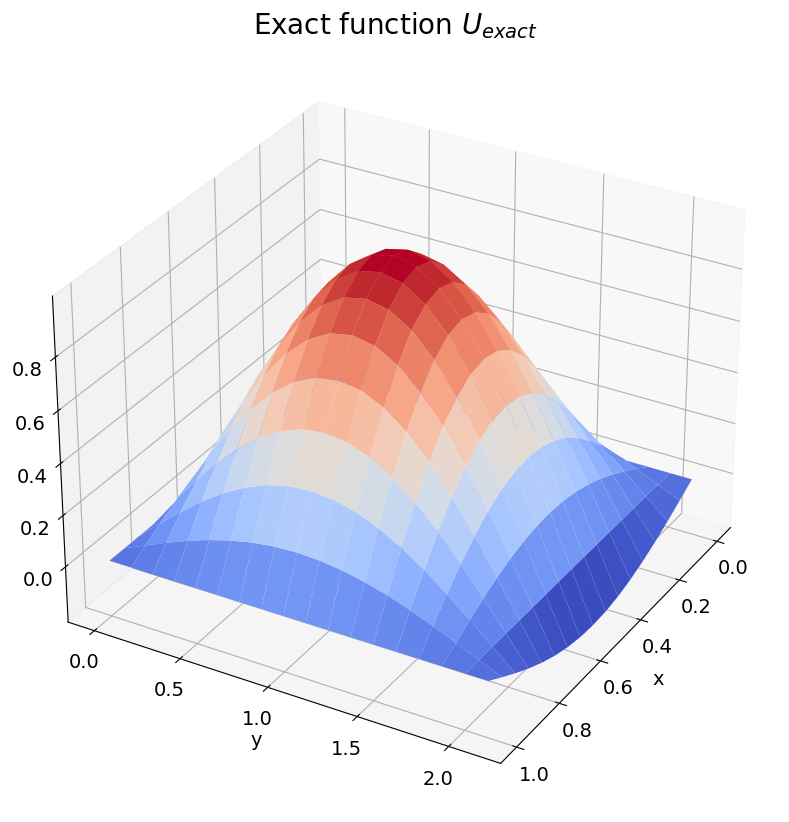

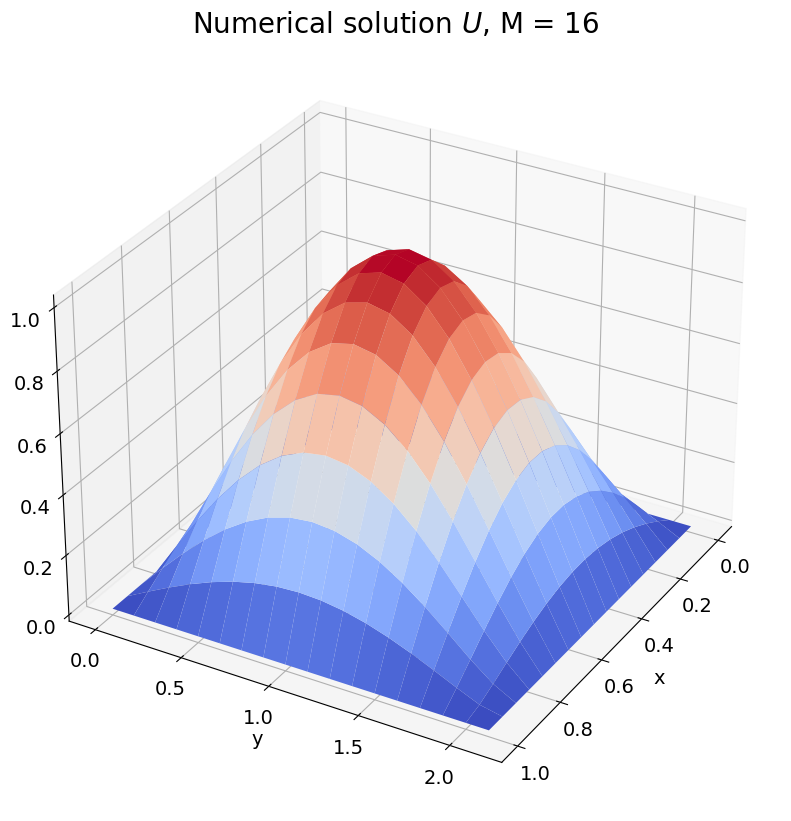

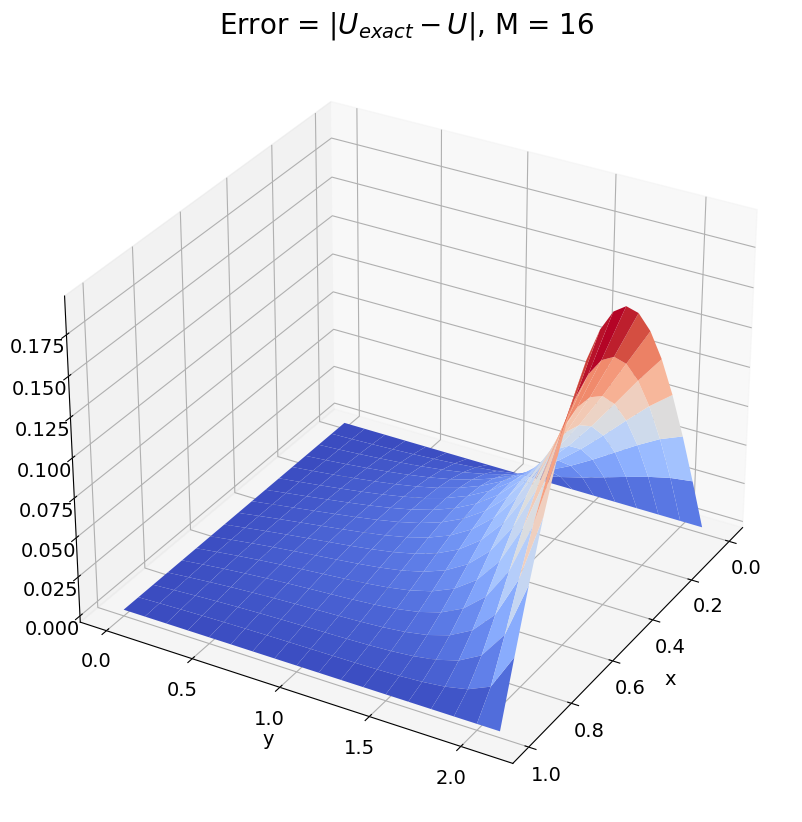

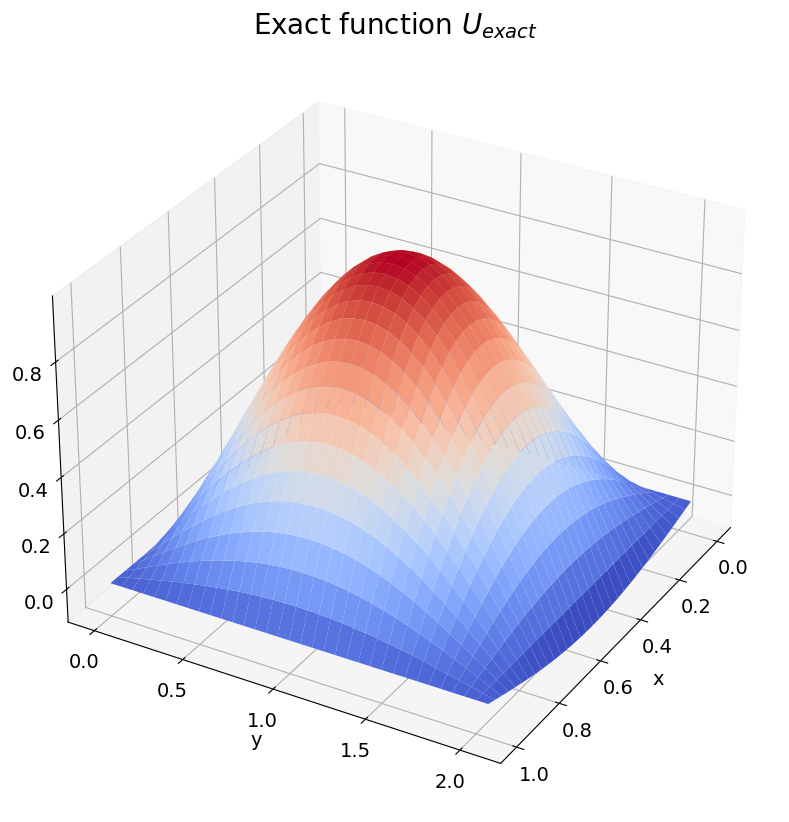

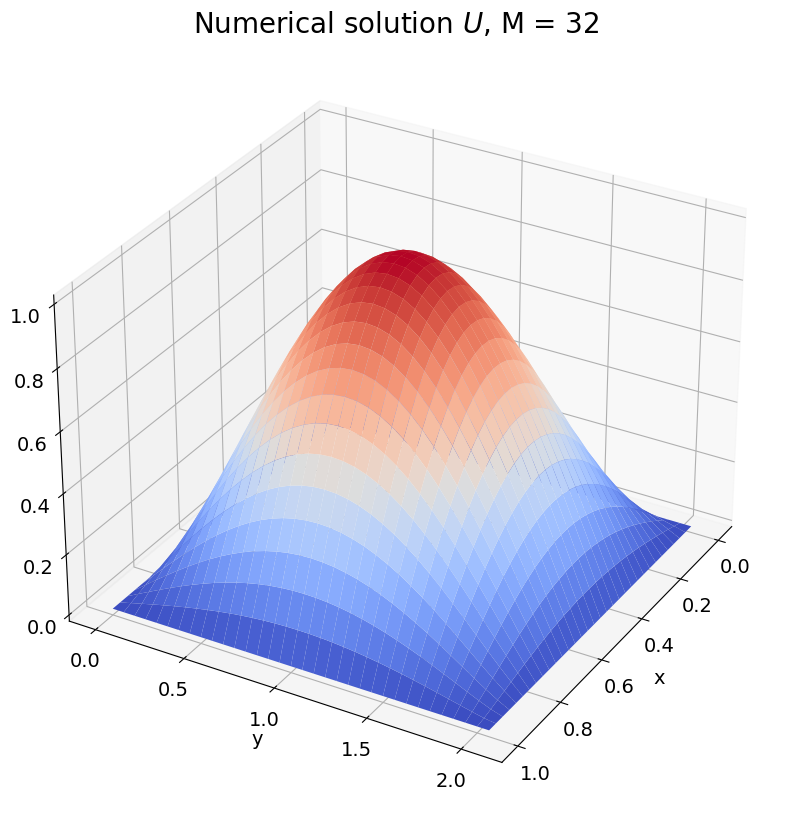

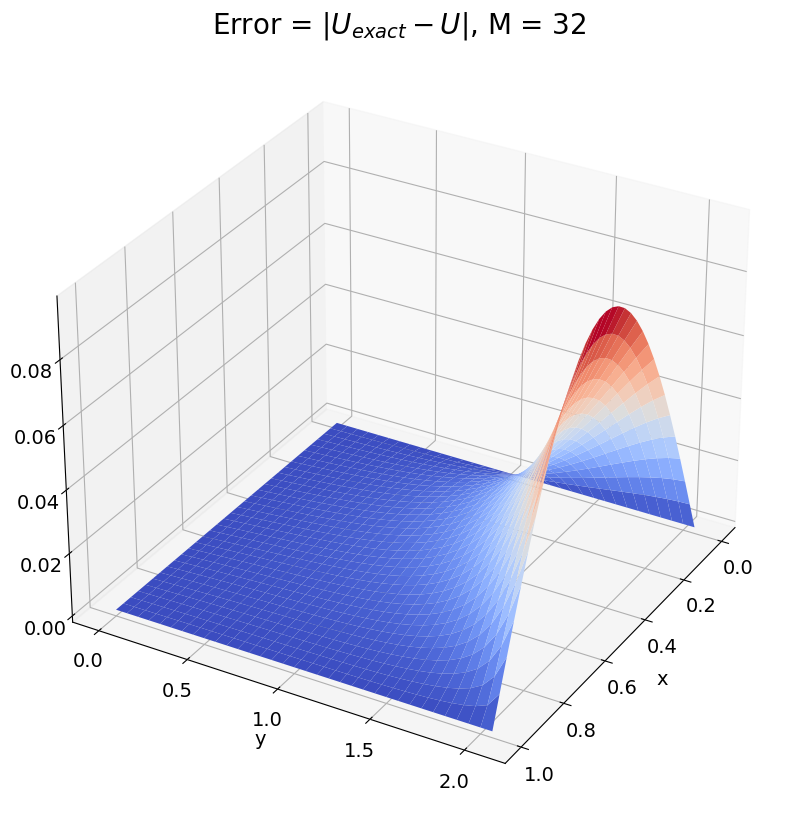

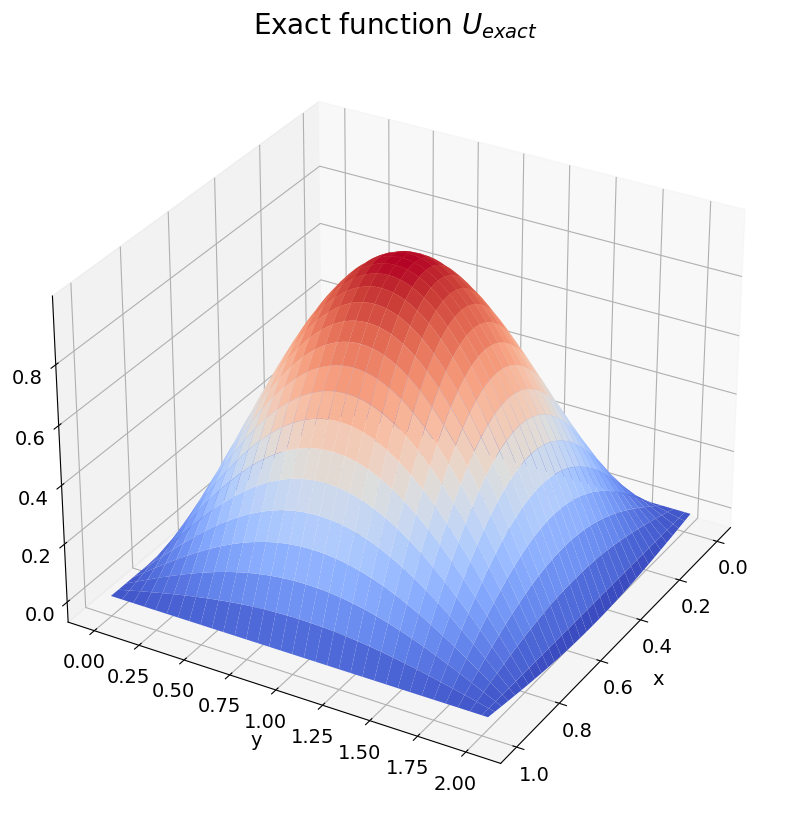

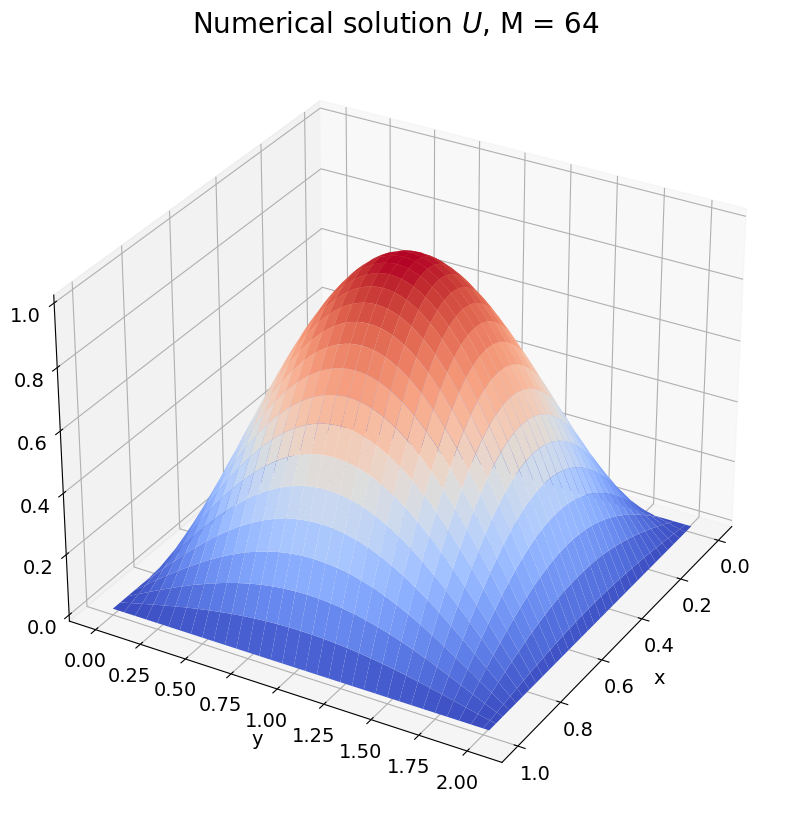

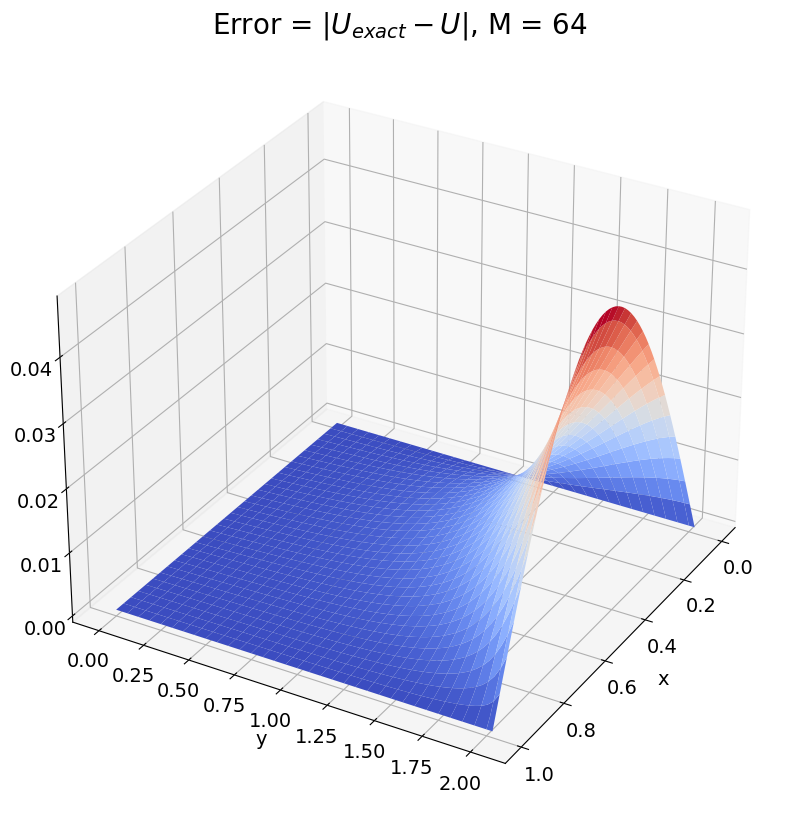

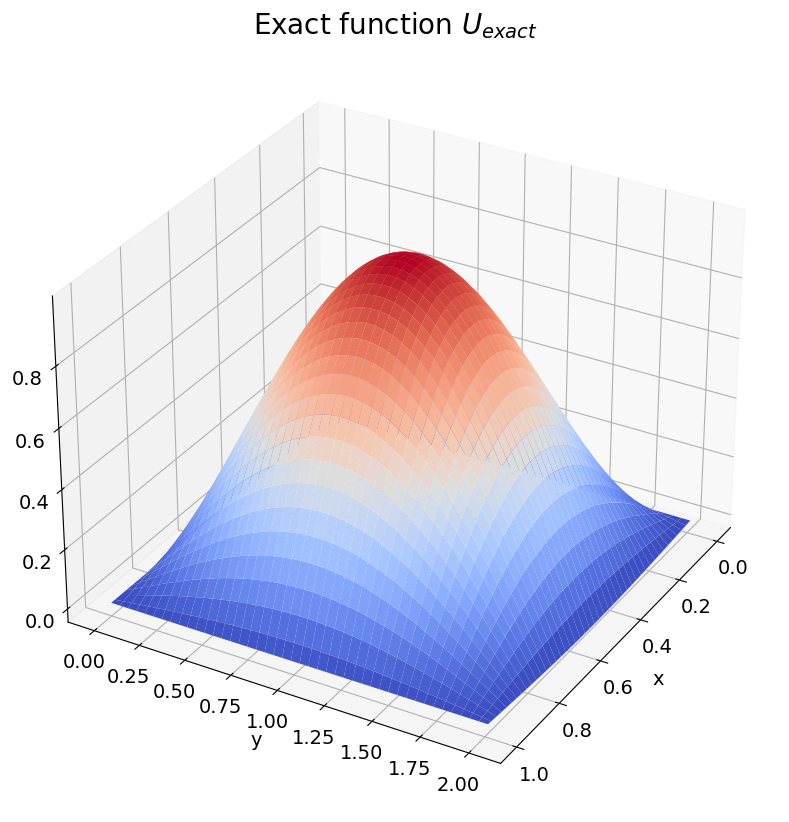

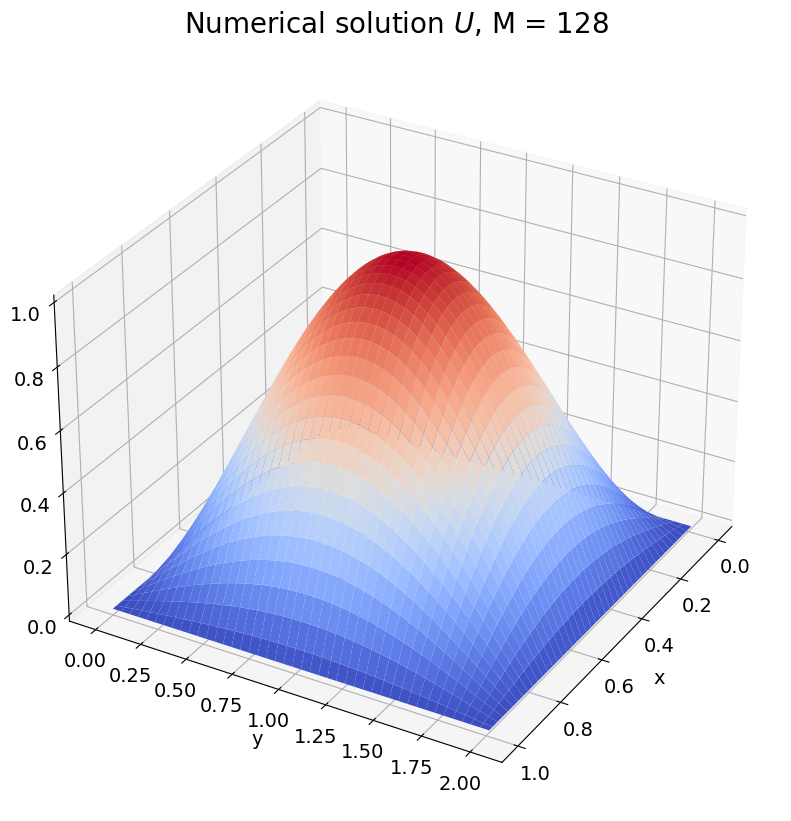

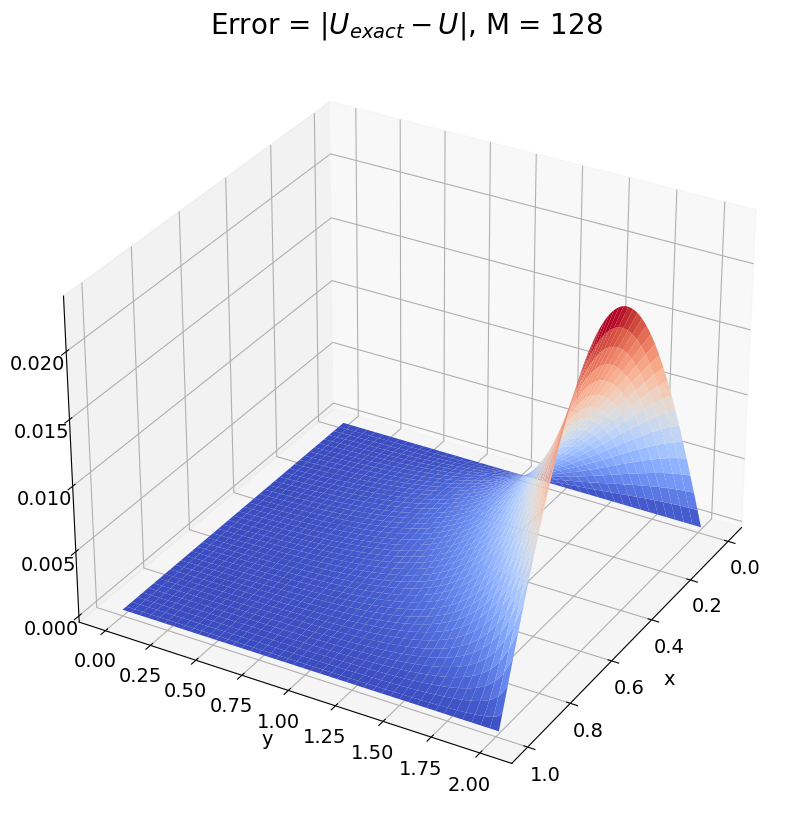

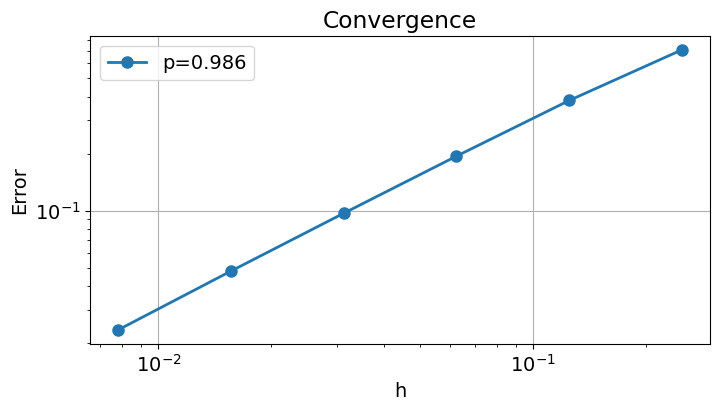

In [18]:

small_float = 0.001
r_val_temp_below = 2*(np.pi)/(np.pi+small_float)
r_val_temp_above = 2*(np.pi)/(np.pi-small_float)

convergence(u_exact1, rhs_func_1, r_val=r_val_temp_below, P=6, M_start=4, plot = True, plot_testing=[True, True, True])

#convergence(u_exact1, rhs_func_1, r_val=r_val_temp_above, P=6, M_start=4, plot = True, plot_testing=[False, False, False])
#convergence(u_exact1, rhs_func_1, r_val=np.pi, P=4, M_start=20, plot = True, plot_testing=[True, True, True])

In [19]:
small_float = 0.00001
r_val_temp_below = 2*(np.pi)/(np.pi+small_float)
r_val_temp_above = 2*(np.pi)/(np.pi-small_float)

r_naive = np.sqrt(2)

Hconv_below, Econv_below, order_below = convergence(u_exact1, rhs_func_1, r_val=r_val_temp_below, P=6, M_start=4)
Hconv_above, Econv_above, order_above = convergence(u_exact1, rhs_func_1, r_val=r_val_temp_above, P=6, M_start=4)
Hconv_exact, Econv_exact, order_exact = convergence(u_exact1, rhs_func_1, r_val=2, P=6, M_start=4)
Hconv_naive, Econv_naive, order_naive = convergence(u_exact1, rhs_func_1, r_val=r_naive, P=6, M_start=4)


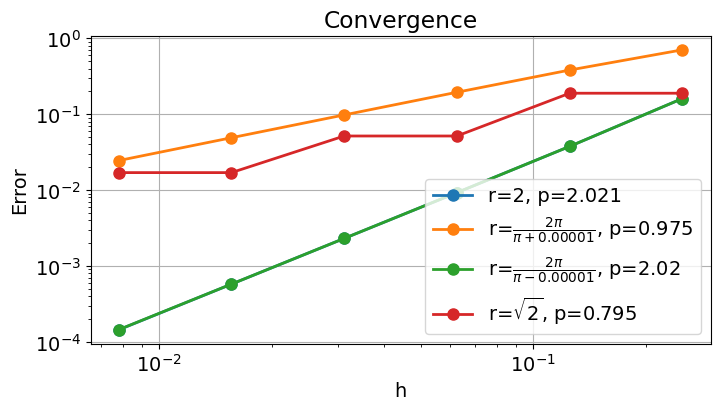

In [20]:
plt.loglog(Hconv_exact,Econv_exact,'o-', label = f"r={2}, p={round(order_exact, 3)}")
# plt.loglog(Hconv_below,Econv_below,'o-', label = f"r={round(r_val_temp_below, 6)}, p={round(order_below, 3)}")

plt.loglog(Hconv_below,Econv_below,'o-', label = r"r=$\frac{2\pi}{\pi+0.00001}$" + f", p={round(order_below, 3)}")

# plt.loglog(Hconv_above,Econv_above,'o-', label = f"r={round(r_val_temp_above, 6)}, p={round(order_above, 3)}")
plt.loglog(Hconv_above,Econv_above,'o-', label = r"r=$\frac{2\pi}{\pi-0.00001}$" + f", p={round(order_above, 3)}")

plt.loglog(Hconv_naive,Econv_naive,'o-', label = r"r=$\sqrt{2}$" + f", p={round(order_naive, 3)}")

plt.title(r"Convergence")
plt.grid('on')
plt.xlabel('h')
plt.ylabel(r'Error')
plt.legend()
plt.show()

# Task 2